In [36]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, TimeSeriesOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from dike_model_function_time_series import DikeNetworkTS  # @UnresolvedImport
from problem_formulation_actors import get_model_for_actor_problem_formulation

In [37]:
# Problem formulations:
#    get_model_for_actor_problem_formulation(problem_formulation_id, outcome_type='time_series')
#    problem_formulation_id options
#        1 - RWS (GOOD)
#        2 - Environmental interest group
#        3 - Transport company 
#        4 - Delta commission
#        5 - Gelderland (GOOD)
#        6 - Overijssel (GOOD)s
#        7 - Dike rings 1 and 2
#        8 - Dike ring 3
#        9 - Dike ring 4
#        10 - Dike ring 5
#
#    outcome_type options
#        'time_series' (default)
#        'scalar'


model, planning_steps = get_model_for_actor_problem_formulation(1, outcome_type='scalar')

# Global SA over Uncertainties

In [38]:
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy, MultiprocessingEvaluator)

from SALib.analyze import sobol

In [39]:
# Reproducing the uncertainties defined in the dike model
# It does not matter which problem formulation id is used here, since the uncertainties are the same in every PF

uncertainties = []
for unc in model.uncertainties:
    uncertainties.append(unc)
    
levers = []
for lev in model.levers:
    levers.append(lev)

# Transferring the uncertainties to the desired SALib problem format
problem = get_SALib_problem(uncertainties)

In [40]:
outcomes = model.outcomes
levers = model.levers

In [41]:
outcomes

In [42]:
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 132), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (0, 3), (0, 3), (0, 3)]}


In [43]:
n_scenario = 5

with MultiprocessingEvaluator(model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(scenarios=n_scenario,
                                                        uncertainty_sampling=SOBOL)

'DikeIncrease 0'
Traceback (most recent call last):
  File "/Users/philipseijger/anaconda3/lib/python3.7/site-packages/ema_workbench/em_framework/experiment_runner.py", line 84, in run_experiment
    model.run_model(scenario, policy)
  File "/Users/philipseijger/anaconda3/lib/python3.7/site-packages/ema_workbench/util/ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "/Users/philipseijger/anaconda3/lib/python3.7/site-packages/ema_workbench/em_framework/model.py", line 338, in run_model
    outputs = self.run_experiment(experiment)
  File "/Users/philipseijger/anaconda3/lib/python3.7/site-packages/ema_workbench/util/ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "/Users/philipseijger/anaconda3/lib/python3.7/site-packages/ema_workbench/em_framework/model.py", line 391, in run_experiment
    model_output = self.function(**experiment)
  File "/Users/philipseijger/Dropbox (Personal)/EPA/EPA1361-ModelBasedDecisionMaking/mbdm_1_RfR/Sens

KeyboardInterrupt: 

In [53]:
# Expected Annual Damage Sobol outcomes
EAD_final_sobol = outcomes_sobol['Expected Annual Damage']
EAD_score = sobol.analyze(problem, EAD_final_sobol, calc_second_order=True, print_to_console=False)

# Total Investment Costs Sobol outcomes
TIC_final_sobol = outcomes_sobol['Total Investment Costs']
TIC_score = sobol.analyze(problem, TIC_final_sobol, calc_second_order=True, print_to_console=False)

# Expected Number of Deaths Sobol outcomes
END_final_sobol = outcomes_sobol['Expected Number of Deaths']
END_score = sobol.analyze(problem, END_final_sobol, calc_second_order=True, print_to_console=False)

In [63]:
def plot_sobol_interaction(sobol_score):
    Si_filter = {k:sobol_score[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(16,12)
    fig.subplots_adjust(bottom=0.3)
    plt.title('Sobol Score')
    ax.set(xlabel='Uncertainty', ylabel='Fraction of total variance')
    plt.show()

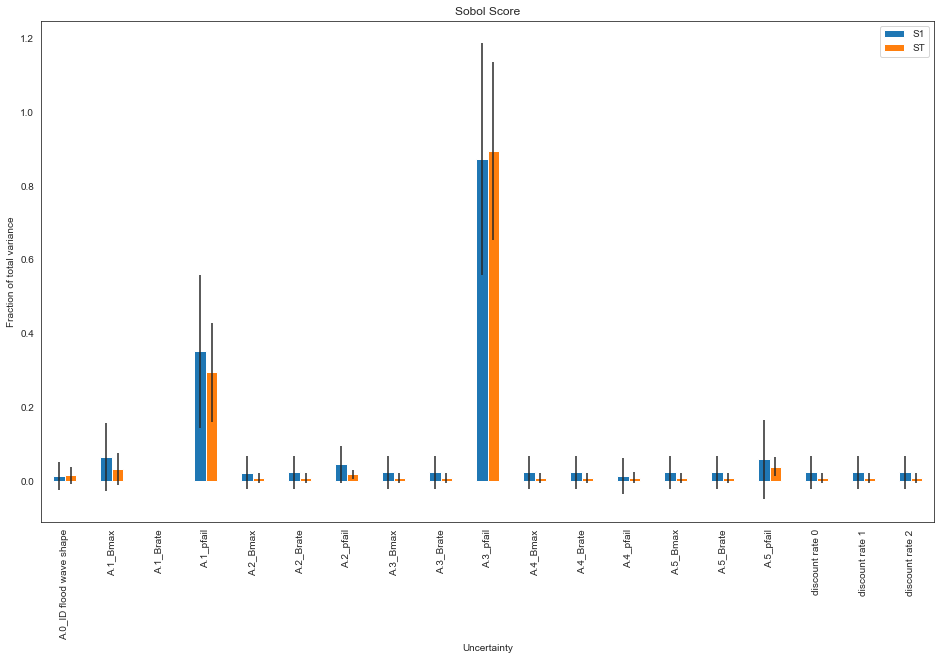

In [65]:
plot_sobol_interaction(END_score)

In [87]:
# We can also study the convergence of the Sobol indices as a function of the number of samples,
# by computing the indices over a partial sample:

def plot_sobol_convergence(final_sobol):

    s_data = pd.DataFrame(index=problem['names'],
                          columns=np.arange(2,n_exp,5)*(2*problem['num_vars']+2))
    for j in s_data.columns:
        scores = sobol.analyze(problem, final_sobol[0:j], calc_second_order=True, print_to_console=False)
        s_data.loc[:,j] = scores['ST']
        
    fig, ax = plt.subplots(1)

    s_data.T.plot(ax=ax)
    ax.set_xlabel('Samples')
    ax.set_ylabel('Total index (ST)')
    plt.title('Sobol Convergence')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

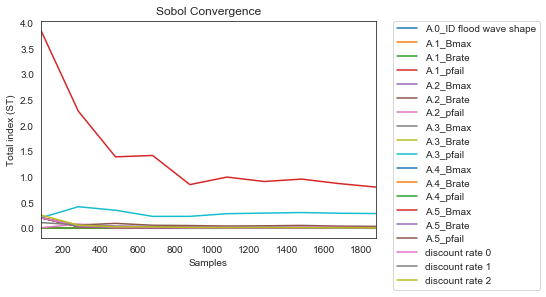

In [88]:
plot_sobol_convergence(EAD_final_sobol)